In [1]:
from potes1DCNN import heartnet, reshape_folds
import tables
import ast # for list import
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [193]:
foldname='fold3'
load_path='/media/taufiq/Data/heart_sound/models/fold3 2017-12-20 14:43:16.922783/weights.0080-0.8165.hdf5'
#load_path='/media/taufiq/Data/heart_sound/models/fold2 2017-12-20 12:14:09.278081/weights.0077-0.8860.hdf5'
#load_path='/media/taufiq/Data/heart_sound/remoteIICTweights/fold1 2017-12-20 15:26:47.011204/weights.0091-0.8898.hdf5'
#load_path='/media/taufiq/Data/heart_sound/models/fold0 2017-12-20 16:10:31.624027/weights.0189-0.7399.hdf5'

## Import Model

In [194]:
random_seed=1
batch_size=64
fold_dir='/media/taufiq/Data/heart_sound/feature/potes_1DCNN/balancedCV/folds/'
log_dir= '/media/taufiq/Data/heart_sound/Heart_Sound/codes/logs/'
bn_momentum = 0.99
eps= 1.1e-5
bias=False
l2_reg=0.
l2_reg_dense=0.
kernel_size=5
maxnorm=10000.
dropout_rate=0.5
dropout_rate_dense=0.
padding='valid'
activation_function='relu'
subsam=2

lr=0.0007
lr_decay=1e-8

model = heartnet(activation_function,bn_momentum,bias,dropout_rate,dropout_rate_dense,
		eps,kernel_size,l2_reg,l2_reg_dense,load_path,lr,lr_decay,maxnorm,
		padding,random_seed,subsam)


## Import Data

In [195]:
feat = tables.open_file(fold_dir+foldname+'.mat')
x_val = feat.root.valX[:]
y_val = feat.root.valY[0,:]
val_parts = feat.root.val_parts[0,:]
y_qual = feat.root.valY[1,:]

for i in range(y_val.shape[0]):
	if y_val[i]==-1:
		y_val[i]=0
		
_,y_qual,x_val,y_val=reshape_folds(np.random.randn(4,4,4),x_val,y_qual,y_val)
print 'loading complete'

(4, 4, 1)
(10224, 1)
(10224, 2500, 1)
(10224, 1)
loading complete


In [196]:
y_pred=model.predict(x_val)
print y_pred

[[ 0.92460907]
 [ 0.85347527]
 [ 0.901685  ]
 ..., 
 [ 0.13838668]
 [ 0.37544772]
 [ 0.1953308 ]]


In [197]:
true = []
pred=[]
qual=[]
start_idx = 0
print val_parts.shape
for s in val_parts:	
	
	if s==0:		## for e1,32,39,44 in validation0 there was no cardiac cycle
            pred.append(0)
            true.append(0)
            qual.append(0)
            continue 
	#~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)
					
	temp_ = np.mean(y_val[start_idx:start_idx+int(s)-1])
	temp = np.mean(y_pred[start_idx:start_idx+int(s)-1,:])
	qual_ = np.mean(y_qual[start_idx:start_idx+int(s)-1,:])
	
	pred.append(temp)
	true.append(temp_)
	qual.append(qual_)
	
	start_idx = start_idx + int(s)		

true=np.array(true)
pred=np.array(pred)
qual=np.array(qual)

(342,)


## Import List of recordings

In [198]:
list_path='/media/taufiq/Data/heart_sound/feature/potes_1DCNN/balancedCV/'+'validation'+foldname[4]+'.txt'
import pandas as pd
val_list=pd.read_csv(list_path,header=None)
val_list=val_list.values
flat_list = [item[0] for sublist in val_list for item in sublist]
flat_list=sorted(flat_list)

## Create DataFrame

In [199]:
flat_list=pd.DataFrame(flat_list)
flat_list['Index']=pd.DataFrame(range(0,val_parts.shape[0]))
flat_list['True']=pd.DataFrame(true)
flat_list['Pred']=pd.DataFrame(pred)
flat_list['Error']=pd.DataFrame(abs(true-pred))

## Scatter Plot different datasets with color

a-Normal-5
b-Normal-4
c-Normal-nan
d-Normal-2
e-Normal-0
f-Normal-0
a-Abnormal-70
b-Abnormal-10
c-Abnormal-4
d-Abnormal-7
e-Abnormal-42
f-Abnormal-1


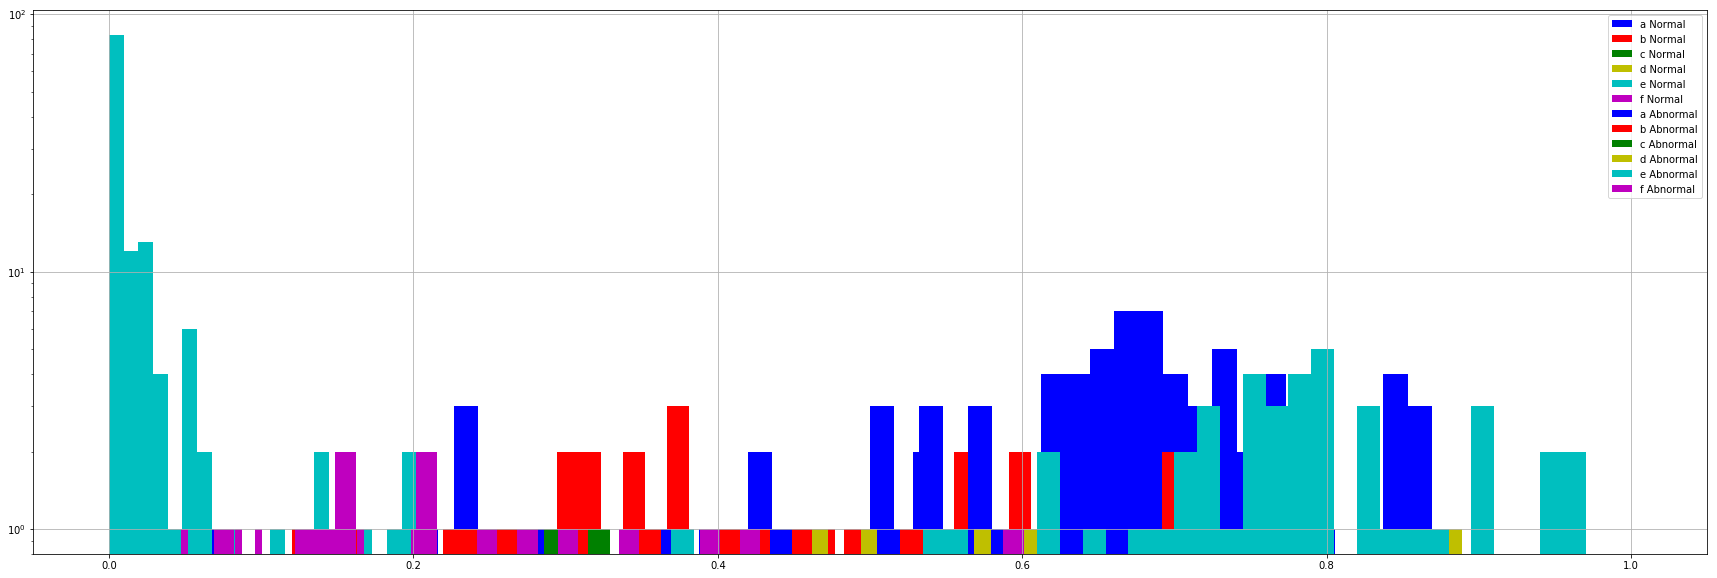

In [218]:
mpl.rcParams['figure.figsize']=(30,10)
for label,marker,name in zip([0,1],['o','^'],['Normal','Abnormal']):
    for dataset,color in zip(['a','b','c','d','e','f'],['b','r','g','y','c','m']):
        x = flat_list['Index'][flat_list[0]==dataset][flat_list['True']==label]
        y = flat_list['Pred'][flat_list[0]==dataset][flat_list['True']==label]
        print '{}-{}-{}'.format(dataset,name,np.sum(y>.5))
        plt.hist(y,40,stacked=True,color=color,label=dataset+' '+name)
#plt.xticks(range(0,len(flat_list),20),rotation='vertical')
#plt.xlim(0,len(flat_list))
#plt.ylim(0,1)
#plt.title('Absolute error vs recordings for '+foldname)
#plt.xlabel('Recording #')
#plt.ylabel('Absolute Error |True-Pred|')
plt.yscale('log',nonposy='clip')
#plt.xscale('log')
#plt.ylim(1,100)
plt.legend()
plt.grid()
plt.show()

## Plot Signal

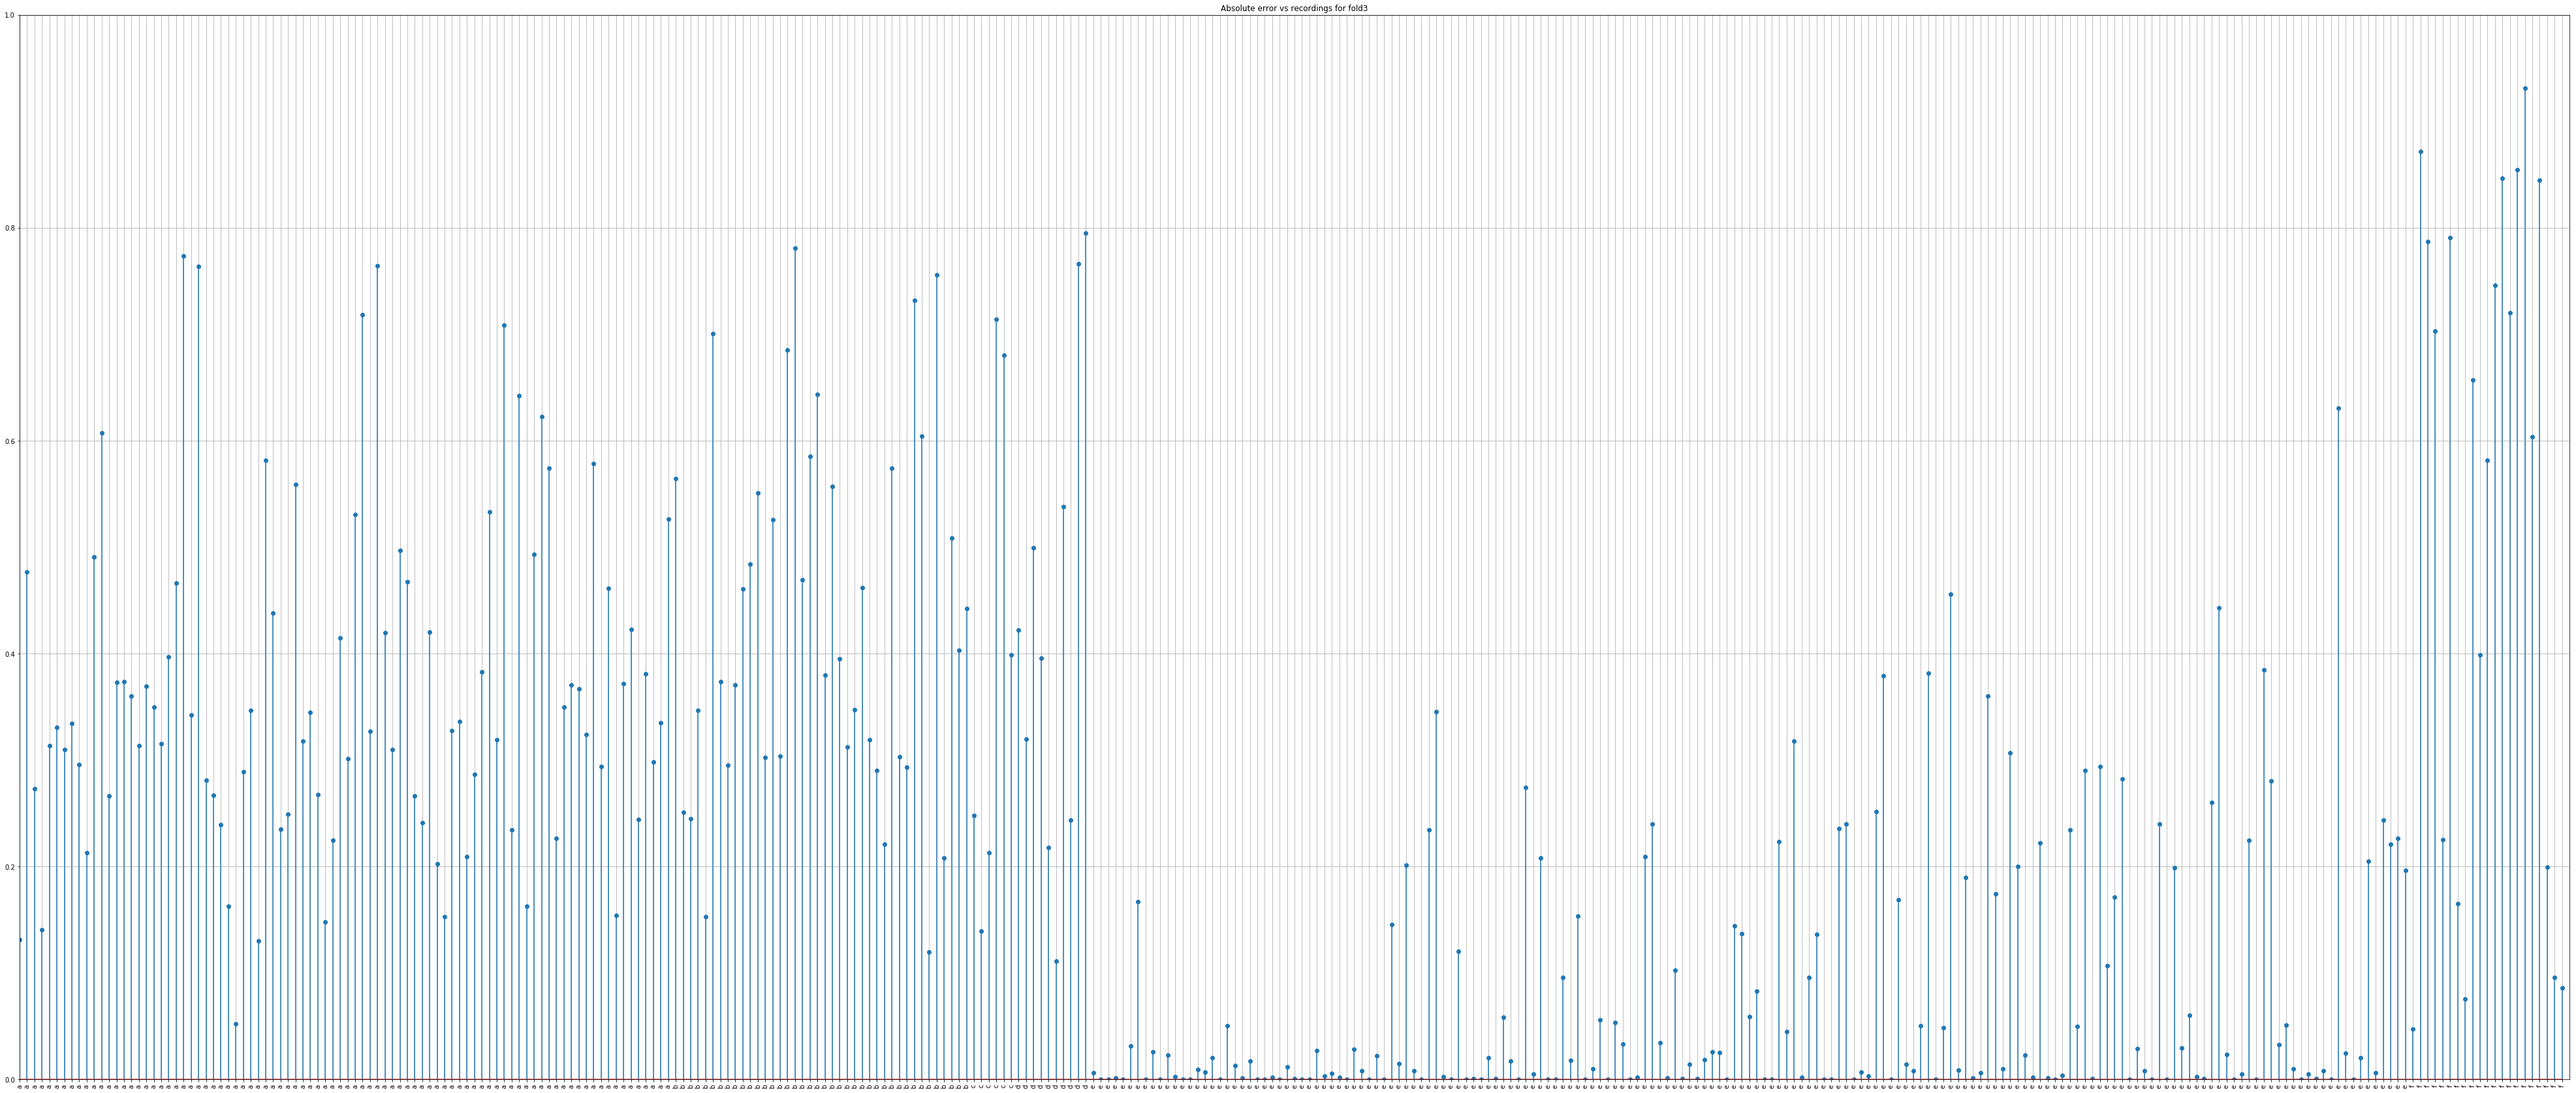

In [71]:
mpl.rcParams['figure.figsize']=(70,30)
plt.stem(range(0,true.shape[0]),((true-pred)**2)**.5)
plt.stem(range(0,true.shape[0]),true,'y--',linewidth=.002)
plt.xticks(range(0,len(flat_list)),flat_list,rotation='vertical')
plt.title('Absolute error vs recordings for '+foldname)
plt.xlim(0,len(flat_list))
plt.ylim(0,1)
plt.grid()
plt.show()

In [65]:
tolerance_thresh=.6
print "{} Abnormal recordings strongly mislabeled".format(sum((((true-pred)**2)**.5)*true>tolerance_thresh))
print "{} Normal recordings strongly mislabeled".format(sum((((true-pred)**2)**.5)*(1-true)>tolerance_thresh))


27 Abnormal recordings strongly mislabeled
5 Normal recordings strongly mislabeled
